# Reinforcement Learning with Function Approximation

In [5]:
!pip install torch==1.2.0 torchvision pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym
!sudo apt-get install xvfb
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1
!cd mvarl_hands_on && git pull origin master > /dev/null 2>&1

     |████████████████████████████████| 748.9MB 19kB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 1.2.0 which is incompatible.
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.3 [783 kB]
Fetched 783 kB in 1s (675 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based front

**Path**, **Pandas**, **base64**, **itertools**, **seaborn**,**copy** and **math** were also imported to make the rest of the code work properly.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

import numpy as np

import gym
from gym.wrappers import Monitor
from pprint import pprint
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

## Added
import pandas as pd
from pathlib import Path
import base64
import itertools 
import seaborn as sns
import copy
import math


# The following code is will be used to visualize the environments.

def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start();

def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


PyTorch is a Python package that provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autograd system

At a granular level, PyTorch is a library that consists of the following components:

| Component | Description |
| ---- | --- |
| [**torch**](https://pytorch.org/docs/stable/torch.html) | a Tensor library like NumPy, with strong GPU support |
| [**torch.autograd**](https://pytorch.org/docs/stable/autograd.html) | a tape-based automatic differentiation library that supports all differentiable Tensor operations in torch |
| [**torch.jit**](https://pytorch.org/docs/stable/jit.html) | a compilation stack (TorchScript) to create serializable and optimizable models from PyTorch code  |
| [**torch.nn**](https://pytorch.org/docs/stable/nn.html) | a neural networks library deeply integrated with autograd designed for maximum flexibility |
| [**torch.multiprocessing**](https://pytorch.org/docs/stable/multiprocessing.html) | Python multiprocessing, but with magical memory sharing of torch Tensors across processes. Useful for data loading and Hogwild training |
| [**torch.utils**](https://pytorch.org/docs/stable/data.html) | DataLoader and other utility functions for convenience |


**Tutorials on PyTorch:** https://pytorch.org/tutorials/


## OpenAI gym
We will consider environments provided by OpenAI gym
This library provides a large number of environments to test RL algorithm.

We will focus on the **CartPole-v1** environment in this lab but we encourage you to also test your code on:
* **Acrobot-v1**
* **MountainCar-v0**

| Env Info          	| CartPole-v1 	| Acrobot-v1                	| MountainCar-v0 	|
|-------------------	|-------------	|---------------------------	|----------------	|
| **Observation Space** 	| Box(4)      	| Box(6)                    	| Box(2)         	|
| **Action Space**      	| Discrete(2) 	| Discrete(3)               	| Discrete(3)    	|
| **Rewards**           	| 1 per step  	| -1 if not terminal else 0 	| -1 per step    	|

A gym environment is loaded with the command `env = gym.make(env_id)`. Once the environment is created, you need to reset it with `observation = env.reset()` and then you can interact with it using the method step: `observation, reward, done, info = env.step(action)`.

In [0]:
# We load CartPole-v1
env = gym.make('CartPole-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True)

In [8]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

## REINFORCE

**Q1: Implement the REINFORCE algorithm**

The code is splitted in two parts:
* The Model class defines the architecture of our neural network which takes as input the current state and returns the policy,
* The Agent class is responsible for the training and evaluation procedure. You will need to code the method `optimize_model`.

In [0]:
class Model(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(Model, self).__init__()
        
        self.n_actions = n_actions
        self.dim_observation = dim_observation
        
        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )
        
    def forward(self, state):
        return self.net(state)
    
    def select_action(self, state):
        action = torch.multinomial(self.forward(state), 1)
        return action

Create the model based on the properties of the MDP you want to solve

In [10]:
env_id = 'CartPole-v1'
env = gym.make(env_id)
model = Model(env.observation_space.shape[0], env.action_space.n)
print(f'The model we created correspond to:\n{model}')

The model we created correspond to:
Model(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Softmax(dim=0)
  )
)


We provide a base agent that you will need to extend in the next cell with your implementation of `optimize_model`.

Only change in **BaseAgent** : np.mean() and np.std() instead of attributes .mean() and .std() since *rewards* is a list and not an array.

In [0]:
class BaseAgent:
    
    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.model = Model(self.env.observation_space.shape[0], self.env.action_space.n)
        self.gamma = config['gamma']
        
        # the optimizer used by PyTorch (Stochastic Gradient, Adagrad, Adam, etc.)
        self.optimizer = torch.optim.Adam(self.model.net.parameters(), lr=config['learning_rate'])
        self.monitor_env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)
    
    # Method to implement
    def _compute_returns(self, rewards):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            The array of rewards of one episode

        Returns
        -------
        array
            The cumulative discounted rewards at each time step
            
        Example
        -------
        for rewards=[1, 2, 3] this method outputs [1 + 2 * gamma + 3 * gamma**2, 2 + 3 * gamma, 3] 
        """
        
        raise NotImplementedError
    
    # Method to implement
    def optimize_model(self, n_trajectories):
        """Perform a gradient update using n_trajectories

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expectation card(D) in the formula above
        
        Returns
        -------
        array
            The cumulative discounted rewards of each trajectory
        """
        
        raise NotImplementedError
    
    def train(self, n_trajectories, n_update):
        """Training method

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        
        rewards = []
        for episode in range(n_update):
            rewards.append(self.optimize_model(n_trajectories))
            print(f'Episode {episode + 1}/{n_update}: rewards {round(np.mean(rewards[-1]), 2)} +/- {round(np.std(rewards[-1]), 2)}')
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
    def evaluate(self, render=False):
        """Evaluate the agent on a single trajectory            
        """
        with torch.no_grad():
            observation = self.monitor_env.reset()
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode = 0
            done = False
                
            while not done:
                action = self.model.select_action(observation)
                observation, reward, done, info = self.monitor_env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                reward_episode += reward
            
            self.monitor_env.close()
            if render:
                show_video("./gym-results")
                print(f'Reward: {reward_episode}')
            print(f'Reward: {reward_episode}')

Finally you can implement your agent

In [0]:
class REINFORCE(BaseAgent):
    
    def _compute_returns(self, rewards):
        
        for i in range(len(rewards)):
            for j in range(i,len(rewards)):
                rewards[i] += rewards[j] * gamma**(j-i)
        return rewards
    
        
    def optimize_model(self, n_trajectories):

        reward_trajectories = []
        loss = 0

        for i in range(n_trajectories):
            #Initialization
            states=[]
            actions=[]
            rewards=[]
            state = torch.Tensor(self.env.reset())

            # While loop until goal reached 
            done = False
            while not done:
                states.append(state)
                # Choose the nex action to do
                action = self.model.select_action(state).item()
                actions.append(action)

                # Doing the action
                next_state, reward, done, info = self.env.step(action)

                # Updating the state and logging the reward
                state = torch.Tensor(next_state)
                rewards.append(reward)

            # Computing the trajectory of the rewards
            trajectory = self._compute_returns(np.array(rewards))
            reward_trajectories.append(trajectory[0])

            # Updating the cumulated loss
            for t in range(len(states)):
                loss += trajectory[t] * torch.log((self.model.forward(states[t])[actions[t]]))

        # Average loss
        loss = - loss/n_trajectories
        
        # The following lines take care of the gradient descent step for the variable loss
        # that you need to compute.
        
        # Discard previous gradients
        self.optimizer.zero_grad()

        # Compute the gradient 
        loss.backward()

        # Do the gradient descent step
        self.optimizer.step()


        return reward_trajectories
    

### Testing the reinforcement on the Cart and Pole config

#### Setting up the environment

In [13]:
env_id = 'CartPole-v1'
learning_rate = 0.01
gamma = 1 
seed = 1235

config = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma
}

print("Current config is:")
pprint(config)


Current config is:
{'env_id': 'CartPole-v1', 'gamma': 1, 'learning_rate': 0.01, 'seed': 1235}


#### Launching the learning in 50 epochs with 50 trajectories each

Episode 1/50: rewards 17.9 +/- 6.2
Episode 2/50: rewards 24.4 +/- 10.22
Episode 3/50: rewards 22.78 +/- 10.9
Episode 4/50: rewards 24.44 +/- 12.22
Episode 5/50: rewards 24.16 +/- 15.84
Episode 6/50: rewards 25.36 +/- 13.01
Episode 7/50: rewards 25.62 +/- 14.78
Episode 8/50: rewards 25.92 +/- 14.38
Episode 9/50: rewards 27.6 +/- 15.79
Episode 10/50: rewards 26.88 +/- 14.47
Episode 11/50: rewards 29.66 +/- 14.07
Episode 12/50: rewards 30.34 +/- 15.0
Episode 13/50: rewards 27.2 +/- 12.48
Episode 14/50: rewards 28.4 +/- 15.38
Episode 15/50: rewards 29.06 +/- 14.48
Episode 16/50: rewards 39.2 +/- 25.07
Episode 17/50: rewards 37.14 +/- 21.44
Episode 18/50: rewards 34.34 +/- 15.92
Episode 19/50: rewards 34.32 +/- 17.95
Episode 20/50: rewards 41.9 +/- 25.29
Episode 21/50: rewards 34.78 +/- 14.52
Episode 22/50: rewards 44.08 +/- 21.57
Episode 23/50: rewards 43.2 +/- 28.48
Episode 24/50: rewards 49.66 +/- 18.62
Episode 25/50: rewards 47.12 +/- 23.02
Episode 26/50: rewards 54.94 +/- 20.7
Episode 

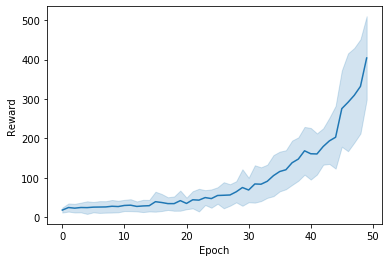

In [14]:
agent = REINFORCE(config)
agent.train(n_trajectories=50, n_update=50)

Evaluate the agent over multiple episodes

In [15]:
agent.evaluate()

Reward: 500.0


## Policy Evaluation as Supervised Learning

**Q2: Implement batched gradient algorithm**

Define network for V-function (ValueNetwork) and policy (ActorNetwork)


In [0]:
class ValueNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).detach().numpy()[0]

In [0]:
class ActorNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

Implement your (batched) gradient algorithm

- *_returns_advantages* is defined the same way as *_compute_returns* in *REINFORCEMENT*

- The optimization is based on a MSE loss on the values.

- The *observations* and *rewards* are updated thanks to *env.step()*.

- The *values* are computed from the *observations* using the *ValueNetwork*.

- The actions are selected thanks to the *policy* wich is an *ActorNetwork*, and is passed as an argument of *EvalAgent*.

In [0]:
class EvalAgent:

    def __init__(self, config, policy):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        self.policy = policy

        # Our network
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)

        # optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), 
                                                   lr=config['value_network']['learning_rate'])
    
    def _returns_advantages(self, rewards):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        returns : array
            The cumulative discounted rewards
        """
        for i in range(len(rewards)):
            for j in range(i,len(rewards)):
                rewards[i] += rewards[j] * gamma**(j-i)

        return rewards
    
    
    def optimize_model(self, observations, returns):
        """Perform a gradient update using provided transitions

        Parameters
        ----------
        observations : array
            The observations
        returns : array
            The returns from each state

        Returns
        -------
        loss_value: int
            The loss value
        """

        returns = torch.tensor(returns[:, None], dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)
        
        # Discard previous gradients
        self.value_network_optimizer.zero_grad()
        
        # Computing the loss
        values = self.value_network(observations)
        loss_mse = F.mse_loss(values, returns)

        # Compute the gradient 
        loss_mse.backward()

        # Do the gradient descent step
        self.value_network_optimizer.step()

        return loss_mse
    
    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        mse_test = []

        for epoch in range(epochs):
            # Lets collect one batch
            for i in range(batch_size):
                observations[i] = observation # current state
                values[i] =   self.value_network(torch.tensor(observation, dtype=torch.float)) #associated value
                actions[i] = self.policy.select_action(torch.tensor(observation, dtype=torch.float)) # choosing the action

                # step
                observation, reward, done, info = self.env.step(int(actions[i]))
                rewards[i]=reward
                dones[i]=done

                if dones[i]:
                    observation = self.env.reset()

            # If our episode didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                next_value = self.value_network(torch.tensor(observation, dtype=torch.float))

            # Update episode_count
            episode_count += sum(dones)

            # Compute returns
            returns = self._returns_advantages(rewards)

            # Learning step !
            self.optimize_model(observations, returns)

            # Test it every 50 epochs
            if epoch % 25 == 0 or epoch == epochs - 1:
                L = []
                for _ in range(10):
                    obs_states, y_mc = self.evaluate()
                    y_hat = self.value_network.predict(torch.tensor(obs_states, dtype=torch.float)) # compute prediction
                    err = y_mc - y_hat
                    mse = np.mean(err**2)
                    L.append(mse.item())
                mse_test.append(L)
                print(f'Epoch {epoch}/{epochs}: MSE: {np.mean(mse)}')

                observation = self.env.reset()

        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], mse_test[i]) for i in range(len(mse_test))))), columns=['Epoch', 'MSE'])
        sns.lineplot(x="Epoch", y="MSE", data=r, ci='sd');

        print(f'The training was done over a total of {episode_count} episodes')

    def evaluate(self, render=False):
        """Returns the observations and the estimated V-function (using first visit Monte-Carlo)

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        states : array
            Observations
        returns : array
            The estimate value function of each state
        """
        env = self.monitor_env if render else self.env
        observation = env.reset()
        states = [observation.copy()]
        rewards= []
        observation = torch.tensor(observation, dtype=torch.float)
        done = False
        steps = 0

        while not done:
            action = self.policy.select_action(torch.tensor(observation, dtype=torch.float))
            observation, reward, done, info = self.env.step(int(action))
            for i in range(steps):
                rewards[i] = rewards[i] + math.pow(self.gamma, steps-i)*reward
            rewards.append(reward)
            if not done:
                states.append(observation.copy())
            observation = torch.tensor(observation, dtype=torch.float)
            steps += 1

        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        states = np.array(states).reshape(-1, self.env.observation_space.shape[0])
        returns = np.array(rewards).reshape(-1,1)
        return states, returns

Define configuration

In [19]:
env_id = 'CartPole-v1'
value_learning_rate = 0.001
gamma = 0.99
seed = 1

config_td = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate, 'reference': './CartPole_value.pt'}
}

print("Current config_td is:")
pprint(config_td)


Current config_td is:
{'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001, 'reference': './CartPole_value.pt'}}


Create policy

In [20]:
env = gym.make(config_td['env_id'])
policy = ActorNetwork(env.observation_space.shape[0], 16, env.action_space.n)
policy.load_state_dict(torch.load('./mvarl_hands_on/data/CartPole_actor.pt'))
state = torch.tensor(np.array(env.reset(), dtype=np.float32))
print("pi(state) = ", policy.select_action(state))
del env

pi(state) =  [0]


Run agent

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0/1000: MSE: 7039.383826365838
Epoch 25/1000: MSE: 6972.846987336033
Epoch 50/1000: MSE: 5125.389845381613
Epoch 75/1000: MSE: 6696.706376655155
Epoch 100/1000: MSE: 6480.275487846108
Epoch 125/1000: MSE: 6185.817507608267
Epoch 150/1000: MSE: 5856.447450343491
Epoch 175/1000: MSE: 5517.125782909547
Epoch 200/1000: MSE: 5178.309854982743
Epoch 225/1000: MSE: 4784.752063067803
Epoch 250/1000: MSE: 4349.362422494465
Epoch 275/1000: MSE: 3921.3024064149467
Epoch 300/1000: MSE: 3509.058556017547
Epoch 325/1000: MSE: 3122.2170918297224
Epoch 350/1000: MSE: 2670.3019581496674
Epoch 375/1000: MSE: 2360.335870830137
Epoch 400/1000: MSE: 2088.001288265924
Epoch 425/1000: MSE: 1777.2616084457138
Epoch 450/1000: MSE: 1519.5987760020332
Epoch 475/1000: MSE: 1358.4102816657605
Epoch 500/1000: MSE: 1178.4446373446178
Epoch 525/1000: MSE: 1077.6638970883423
Epoch 550/1000: MSE: 1002.1742879010264
Epoch 575/1000: MSE: 952.5709494876857
Epoch 600/1000: MSE: 913.4244876488336
Epoch 625/1000: MSE: 

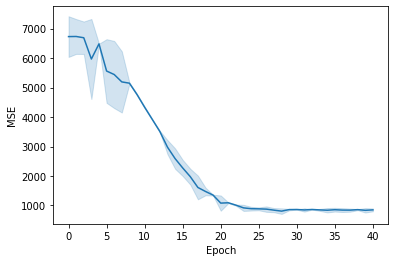

In [21]:
agent = EvalAgent(config=config_td, policy=policy)
agent.training_batch(epochs=1000, batch_size=256)

## Advantage Actor Critic (A2C)
**Q3: Implement the A2C method**

As usual we provide a structure you can use as starting point.



**Note:** try to reuse previous parts of previous code.


- The *_returns_advantages* is similar to the one in *EvalAgent* (except we check when a state is done) + the computation of the temporal difference = advantages between each state.

- The *optimize_model* function is simalr to the one in *EvalAgent* except it takes into account the loss (entropy) of the *ActorNetwork*.

- This time in the function *training_batch*, its the *ActionNetwork* of the A2C that is used to choose the next action.

- We render the environement at the last step.



In [0]:
class A2CAgent:

    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        
        # Our two networks
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)
        self.actor_network = ActorNetwork(self.env.observation_space.shape[0], 16, self.env.action_space.n)
        
        # Their optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), lr=config['value_network']['learning_rate'])
        self.actor_network_optimizer = optim.RMSprop(self.actor_network.parameters(), lr=config['actor_network']['learning_rate'])
    
    def _returns_advantages(self, rewards, dones, values, next_value):
          """Returns the cumulative discounted rewards at each time step

          Parameters
          ----------
          rewards : array
              An array of shape (batch_size,) containing the rewards given by the env
          dones : array
              An array of shape (batch_size,) containing the done bool indicator given by the env
          values : array
              An array of shape (batch_size,) containing the values given by the value network
          next_value : float
              The value of the next state given by the value network
          
          Returns
          -------
          returns : array
              The cumulative discounted rewards
          advantages : array
              The advantages
          """
          ## Returns
          returns=copy.deepcopy(rewards)
          returns[-1] = next_value

          for i in reversed(range(len(returns)-1)):
              # we only update the returns if we are not at a done state
              returns[i] += returns[i+1] * self.gamma * (not dones[i])


          ## Temporal difference
          temporal_diff = np.zeros(np.shape(values))
          for t in range(len(values)):
              if t==len(values)-1: # if last value
                  temporal_diff[t]= rewards[t-1] + self.gamma * next_value -values[t-1]
              else:
                  temporal_diff[t]= rewards[t] + returns[t+1] -values[t]
          advantages = np.zeros(np.shape(values))

          return returns, temporal_diff


    def optimize_model(self, observations, actions, returns, advantages):
        actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        returns = torch.tensor(returns[:, None], dtype=torch.float)
        advantages = torch.tensor(advantages, dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)
        
        # MSE for the values
        # Actor & Entropy loss

        ### Loss MSE for the values
        # Discard previous gradients
        self.value_network_optimizer.zero_grad()
        values = self.value_network(observations)
        loss_mse = F.mse_loss(values, returns)
        # Backward on the loss
        loss_mse.backward()
        # Do the gradient descent steps
        self.value_network_optimizer.step()
 

        ### Loss for the Actor
        # Discard previous gradients
        self.actor_network_optimizer.zero_grad()
        loss_actor = 0
        for i in range(advantages.size()[0]):
            loss_actor -= advantages[i]*torch.log(self.actor_network(observations[i])[torch.argmax(actions[i])])
        # Backward on the loss
        loss_actor.backward()
        # Do the gradient descent steps
        self.actor_network_optimizer.step()

        return loss_mse+loss_actor


    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        probs = []
        rewards_test = []
        observation = self.env.reset()
        for epoch in range(epochs):
            
            # Lets collect one batch
            for i in range(batch_size):
                observations[i] = observation # current state
                values[i] =   self.value_network(torch.tensor(observation, dtype=torch.float)) #associated value
                actions[i] = int(self.actor_network.select_action(torch.tensor(observation, dtype=torch.float))) # choosing the action

                # step
                observation, reward, done, info = self.env.step(int(actions[i]))
                rewards[i]=reward
                dones[i]=done
                
                if dones[i]:
                    observation = self.env.reset()

            # If our episode didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                action = self.actor_network.select_action(torch.tensor(observation,dtype = torch.double).float())
                observation, reward, done, info = self.env.step(int(action))
                next_value = reward
                if done :
                    observation = self.env.reset()


            # Update episode_count
            episode_count += sum(dones)

            # Compute returns
            returns,advantages = self._returns_advantages(rewards, dones, values, next_value)

            # Learning step !
            self.optimize_model(observations, actions, returns, advantages)


            # Test it every 50 epochs
            if epoch % 50 == 0 or epoch == epochs - 1:
                rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
                print(f'Epoch {epoch}/{epochs}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

                # Early stopping
                if rewards_test[-1].mean() > 490 and epoch != epochs -1:
                    print('Early stopping !')
                    break
                observation = self.env.reset()
                    
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
        print(f'The trainnig was done over a total of {episode_count} episodes')


    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False

        while not done:
            policy = self.actor_network(observation)
            action = torch.multinomial(policy, 1)
            observation, reward, done, info = env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

Create configuration for A2C

In [7]:
env_id = 'CartPole-v1'
value_learning_rate = 0.001
actor_learning_rate = 0.001
gamma = 0.99
entropy = 1
seed = 1

config_a2c = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate},
    'actor_network': {'learning_rate': actor_learning_rate},
    'entropy': entropy
}

print("Current config_a2c is:")
pprint(config_a2c)

Current config_a2c is:
{'actor_network': {'learning_rate': 0.001},
 'entropy': 1,
 'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001}}


Run the learning agent

Epoch 0/1000: Mean rewards: 20.08, Std: 9.53
Epoch 50/1000: Mean rewards: 34.42, Std: 17.95
Epoch 100/1000: Mean rewards: 51.88, Std: 27.0
Epoch 150/1000: Mean rewards: 75.18, Std: 43.75
Epoch 200/1000: Mean rewards: 132.9, Std: 77.08
Epoch 250/1000: Mean rewards: 217.34, Std: 89.37
Epoch 300/1000: Mean rewards: 267.46, Std: 96.54
Epoch 350/1000: Mean rewards: 228.76, Std: 77.5
Epoch 400/1000: Mean rewards: 292.38, Std: 107.31
Epoch 450/1000: Mean rewards: 330.88, Std: 109.69
Epoch 500/1000: Mean rewards: 359.1, Std: 97.07
Epoch 550/1000: Mean rewards: 386.44, Std: 111.43
Epoch 600/1000: Mean rewards: 396.86, Std: 111.47
Epoch 650/1000: Mean rewards: 443.8, Std: 70.35
Epoch 700/1000: Mean rewards: 454.38, Std: 85.58
Epoch 750/1000: Mean rewards: 455.02, Std: 75.19
Epoch 800/1000: Mean rewards: 434.24, Std: 82.46
Epoch 850/1000: Mean rewards: 436.4, Std: 92.44
Epoch 900/1000: Mean rewards: 471.14, Std: 70.83
Epoch 950/1000: Mean rewards: 438.44, Std: 83.57
Epoch 999/1000: Mean rewards: 

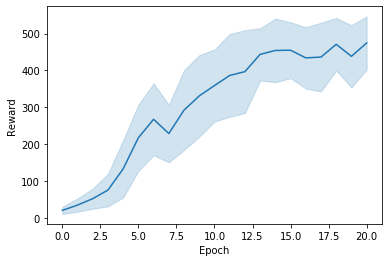

In [8]:
agent = A2CAgent(config_a2c)
rewards = agent.training_batch(1000, 256)

Evaluate the agent over multiple episodes

In [9]:
agent.evaluate(render=True)

Reward: 500.0


500.0